# Prep

In [67]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import glob
%matplotlib inline

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
!pip install kaggle

username = "XXX" 
key = "XXX"        

api_token = {"username": username,"key": key}

!mkdir /root/.kaggle
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [69]:
!kaggle datasets download -d fpeccia/weed-detection-in-soybean-crops

weed-detection-in-soybean-crops.zip: Skipping, found more recently modified local copy (use --force to force download)


In [70]:
print(os.listdir())
!unzip -q weed-detection-in-soybean-crops.zip

['.config', 'dataset', 'weed-detection-in-soybean-crops.zip', 'sample_data']
replace dataset/dataset/broadleaf/1.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [71]:
print(os.listdir())

['.config', 'dataset', 'weed-detection-in-soybean-crops.zip', 'sample_data']


In [0]:
!rm -r ./dataset/broadleaf/*
!rm -r ./dataset/grass/*
!rm -r ./dataset/soil/*
!rm -r ./dataset/soybean/*

## Data augementation

In [0]:
class Data_augmentation:
    def __init__(self, path, image_name):
        self.path = path
        self.name = image_name
        print(path+image_name)
        self.image = cv2.imread(path+image_name)

    def rotate(self, image, angle=90, scale=1.0):
        w = image.shape[1]
        h = image.shape[0]

        M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)

        image = cv2.warpAffine(image,M,(w,h))
        return image

    def flip(self, image, vflip=False, hflip=False):
        if hflip or vflip:
            if hflip and vflip:
                c = -1
            else:
                c = 0 if vflip else 1
            image = cv2.flip(image, flipCode=c)
        return image 
    
    
    def image_augment(self, save_path): 
        img = self.image.copy()
        img_flip = self.flip(img, vflip=True, hflip=False)
        img_rot = self.rotate(img)
        
        name_int = self.name[:len(self.name)-4]
        cv2.imwrite(save_path+'%s' %str(name_int)+'_vflip.jpg', img_flip)
        cv2.imwrite(save_path+'%s' %str(name_int)+'_rot.jpg', img_rot)

In [0]:
def main(file_dir,output_path):
        for root, _, files in os.walk(file_dir):
            print(root)
        for file in files:
            raw_image = Data_augmentation(root,file)
            raw_image.image_augment(output_path)

In [0]:
file_dir = './dataset/dataset/broadleaf/'
output_path = './dataset/broadleaf/'

file_dir = './dataset/dataset/grass/'
output_path = './dataset/grass/'

file_dir = './dataset/dataset/soil/'
output_path = './dataset/soil/'

file_dir = './dataset/dataset/soybean/'
output_path = './dataset/soybean/'

## Data preprocessing

In [0]:
os.chdir('/content/')

classes = ['broadleaf', 'grass', 'soil', 'soybean'] 
data_dir = r'./dataset/dataset/'
directory = data_dir

In [0]:
pathname = os.path.join(directory,classes[0])
broadleaf = os.listdir(pathname)
pathname = os.path.join(directory,classes[1])
grass = os.listdir(pathname)
pathname = os.path.join(directory,classes[2])
soil = os.listdir(pathname)
pathname = os.path.join(directory,classes[3])
soybean = os.listdir(pathname)

In [78]:
print(classes[0] , str(len(broadleaf)))
print(classes[1] , str(len(grass)))
print(classes[2] , str(len(soil)))
print(classes[3] , str(len(soybean)))

broadleaf 1191
grass 3520
soil 3249
soybean 7376


In [0]:
def show_image(filename):
  image = plt.imread(filename,format='tif')
  fig, ax = plt.subplots()
  im = ax.imshow(image)
  plt.show()
  print(image.shape)  

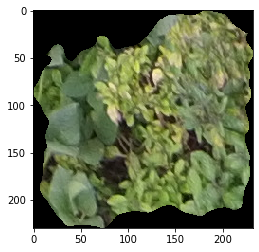

(230, 232, 3)


In [80]:
filename = os.path.join(os.path.join(directory,classes[0]),broadleaf[random.randint(0,len(broadleaf))])
show_image(filename)

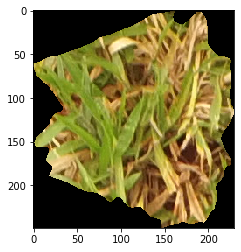

(249, 230, 3)


In [81]:
filename = os.path.join(os.path.join(directory,classes[1]),grass[random.randint(0,len(grass))])
show_image(filename)

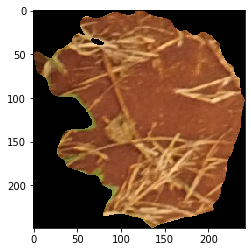

(249, 242, 3)


In [82]:
filename = os.path.join(os.path.join(directory,classes[2]),soil[random.randint(0,len(soil))])
show_image(filename)

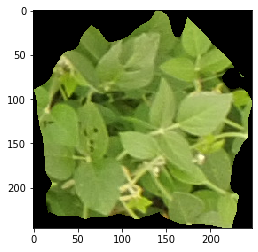

(246, 247, 3)


In [83]:
filename = os.path.join(os.path.join(directory,classes[3]),soybean[random.randint(0,len(soybean))])
show_image(filename)

In [0]:
num2class = {
        0: 'broadleaf', 
        1: 'grass', 
        2: 'soil', 
        3: 'soybean'}

class2num = {
        'broadleaf' : 0, 
        'grass' : 1, 
        'soil' : 2, 
        'soybean' : 3}

In [0]:
m = 1
num_file = 1100 * m
num_train = 1000 * m  
num_val = 50 * m
num_test = 50 * m

all_files = [] 
num_data =num_file*len(classes)
Y = np.zeros(num_data)

for i, cls in enumerate(classes):
    all_files += [f for f in glob.glob(data_dir+cls+'/*.tif')][:num_file]
    Y[i*num_file:(i+1)*num_file] = i

In [0]:
im_width = 200
im_height = 200 
im_channel = 3
dim = im_width * im_height * im_channel

X = np.ndarray(shape=(num_data, im_width, im_height, im_channel), dtype=np.float64)

for idx, file in enumerate(all_files):
    X[idx] = cv2.resize(cv2.imread(file), (im_width, im_height))

X_train = np.empty(shape=(num_train*len(classes),im_width, im_height, im_channel), dtype=np.float64)
X_val = np.empty(shape=(num_val*len(classes),im_width, im_height, im_channel), dtype=np.float64)
X_test = np.empty(shape=(num_test*len(classes),im_width, im_height, im_channel), dtype=np.float64)

y_train = np.empty(num_train*len(classes))
y_val = np.empty(num_val*len(classes))
y_test = np.empty(num_test*len(classes)) 

for i, cls in enumerate(classes): 
    X_test[num_test*i:num_test*(i+1)] = X[np.where(Y == i)[0][:num_test]]
    X_val[num_val*i:num_val*(i+1)] = X[np.where(Y == i)[0][num_test:num_test+num_val]]
    X_train[num_train*i:num_train*(i+1)] = X[np.where(Y == i)[0][num_test+num_val:]]
    
    y_test[num_test*i:num_test*(i+1)] = i
    y_val[num_val*i:num_val*(i+1)] = i
    y_train[num_train*i:num_train*(i+1)] = i

del Y 
del X

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


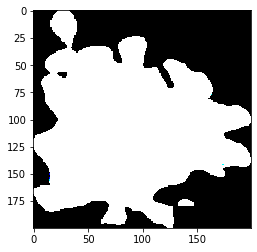

In [87]:
X_train.shape

plt.imshow(X_train[500])

In [88]:
train_idxs = np.random.permutation(X_train.shape[0])
y_train  = y_train[train_idxs].astype(int)
X_train = X_train[train_idxs]

X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype('float64')
X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype('float64')
X_val = np.reshape(X_val, (X_val.shape[0], -1)).astype('float64')

X_tiny = X_train[100:110].astype('float64')
y_tiny = y_train[100:110].astype(int)
num_dev = 500

X_dev = X_train[0:num_dev].astype('float64')
y_dev = y_train[0:num_dev].astype(int)
print("X_train shape", X_train.shape, "| y_train shape:", y_train.shape)
print("X_test shape", X_test.shape, "| y_test shape:", y_test.shape)
print("X_val shape", X_val.shape, "| y_val shape:", y_val.shape)
print("X_dev shape", X_dev.shape, "| y_dev shape:", y_dev.shape)
print("X_tiny shape", X_tiny.shape, "| y_tiny shape:", y_tiny.shape)

mean_image = np.mean(X_train, axis=0)

X_train -= mean_image
X_val -= mean_image 
X_test -= mean_image
X_dev -= mean_image
X_tiny -= mean_image

print('=====STACK BIAS term=====')
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("X_val shape", X_val.shape)
print("X_dev shape", X_dev.shape)
print("X_tiny shape", X_tiny.shape)

X_train shape (4000, 120000) | y_train shape: (4000,)
X_test shape (200, 120000) | y_test shape: (200,)
X_val shape (200, 120000) | y_val shape: (200,)
X_dev shape (500, 120000) | y_dev shape: (500,)
X_tiny shape (10, 120000) | y_tiny shape: (10,)
=====STACK BIAS term=====
X_train shape (4000, 120000)
X_test shape (200, 120000)
X_val shape (200, 120000)
X_dev shape (500, 120000)
X_tiny shape (10, 120000)


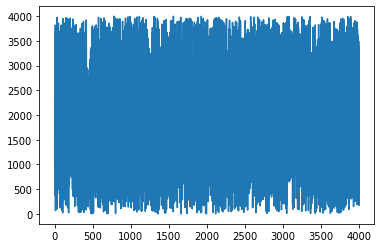

In [89]:
plt.plot(train_idxs)
plt.show()

In [0]:
classes = ['broadleaf', 'grass', 'soil', 'soybean']
n_class = len(classes)
samples_per_class = 4

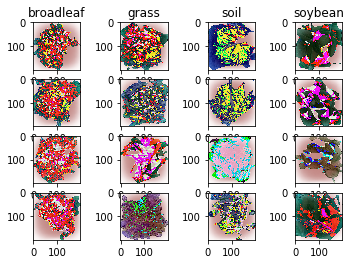

In [91]:
for y, cls in enumerate(classes):
    idxes = np.flatnonzero(y == y_train)
    idxes = np.random.choice(idxes, samples_per_class, replace = False)
    for i, idx in enumerate(idxes):
        plt_idx = i * n_class + y + 1
        plt.subplot(samples_per_class,n_class, plt_idx)
        plt.imshow(X_train[idx].reshape(im_width, im_height, im_channel).astype('uint8'))
        if(i==0): plt.title(cls)

plt.show()

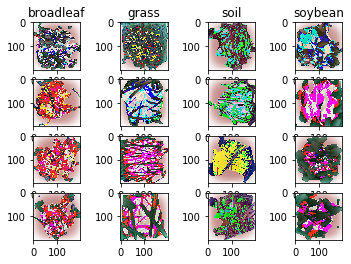

In [92]:
for y, cls in enumerate(classes):
    idxes = np.flatnonzero(y == y_dev)
    idxes = np.random.choice(idxes, samples_per_class, replace = False)
    for i, idx in enumerate(idxes):
        plt_idx = i * n_class + y + 1
        plt.subplot(samples_per_class,n_class, plt_idx)
        plt.imshow(X_dev[idx].reshape(im_width, im_height, im_channel).astype('uint8'))
        if(i==0): plt.title(cls)

plt.show()

In [0]:
class TwoLayerNet():
    def __init__(self, input_size, hidden_size, output_size, std= 1e-4):
        '''
        std: weight initialization term
        W1: first layer weight, shape(D x H) 
        W2: second layer weight shape(H x C) 
        C: num_classes(output_size) , H: hidden_size, D: data_dim(input_size) 
        '''
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def loss(self, X, y = None, reg=0.0):
        '''
        reg: regularization strength
        X: ndarray shape(N x C). N: num of data 
        y: vector of training label
        '''
        relu = lambda x:np.maximum(0,x)

        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        layer1 = relu(X.dot(W1) + b1)
        scores = layer1.dot(W2) + b2

        if(y is None): 
            return scores

        scores -= scores.max()

        scores = np.exp(scores)
        scores_sumexp = np.sum(scores, axis=1)

        softmax = scores / scores_sumexp.reshape(N,1) 
        loss =  (-1.0) * np.sum(np.log(softmax[range(N),y]))

        loss /= N 
        loss += reg * np.sum(W1 * W1) 
        loss += reg * np.sum(W2 * W2) 

        grads = {}

        correct_class_scores = scores[range(N), y]
        softmax[range(N), y] = (-1.0) * (scores_sumexp - correct_class_scores)/scores_sumexp
        softmax /= N

        grads['W2'] = layer1.T.dot(softmax)
        grads['b2'] = np.sum(softmax, axis=0)
        grads['W2'] += reg * 2 * W2

        hidden = softmax.dot(W2.T)

        hidden[layer1 == 0] = 0 

        grads['W1'] = X.T.dot(hidden) 
        grads['b1'] = np.sum(hidden, axis=0)
        grads['W1'] += reg * 2 * W1

        return loss, grads

    def train(self, X, y, X_val, y_val, 
              learning_rate =1e-3, learning_rate_decay=0.95, 
              reg=5e-6, num_iters=100, 
              batch_size=200, it_verbose = 1, verbose=False):
        '''
        Train using SGD 
        Input: 
            X: nd array shape(N x D) 
            y: vector of train label 
            X_val: nd array shape( n_VAL , D) Use as validation set after each epoch 
            y_val: vector of validation label 
        '''
        N, D = X.shape
        N_val = X_val.shape[0]
        iteration_per_epoch = max(N/batch_size, 1)
        
        loss_hist = []
        train_acc_hist = []
        val_acc_hist = []
        
        for it in range(num_iters):
            sampling = np.random.choice(np.arange(N), batch_size, replace=False) 
            X_batch = X[sampling]
            y_batch = y[sampling]
            
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_hist.append(loss) 
            
            self.params['W1'] += (-1.0) * learning_rate * grads['W1']
            self.params['b1'] += (-1.0) * learning_rate * grads['b1']
            self.params['W2'] += (-1.0) * learning_rate * grads['W2']
            self.params['b2'] += (-1.0) * learning_rate * grads['b2']
            
            if(verbose and it%it_verbose==0):
                print('iteration: %d / %d | Loss: %f' % (it, num_iters, loss)) 

            if (it % iteration_per_epoch == 0):

                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_hist.append(train_acc)
                val_acc_hist.append(val_acc)

                learning_rate *= learning_rate_decay
        return {
            'loss_hist':loss_hist,
            'train_acc_hist':train_acc_hist,
            'val_acc_hist':val_acc_hist
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
        classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
        the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
        to have class c, where 0 <= c < C.
        """
        y_pred = None
        relu = lambda x:np.maximum(0,x)

        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        layer1 = relu(X.dot(W1) + b1)
        scores = layer1.dot(W2) + b2
        y_pred = np.argmax(scores, axis=1)

        return y_pred

In [94]:
input_size = im_width * im_height * im_channel
hidden_size = 200
output_size = n_class 
std = 1e-3

net = TwoLayerNet(input_size, hidden_size,output_size,std )

stats = net.train(X_train, y_train, X_val, y_val, 
              learning_rate =1e-5, learning_rate_decay=0.95, 
              reg=0.0, num_iters=500, 
              batch_size=100, it_verbose = 10,verbose=True)

iteration: 0 / 500 | Loss: 1.405148
iteration: 10 / 500 | Loss: 1.369505
iteration: 20 / 500 | Loss: 1.338335
iteration: 30 / 500 | Loss: 1.292174
iteration: 40 / 500 | Loss: 1.275292
iteration: 50 / 500 | Loss: 1.221863
iteration: 60 / 500 | Loss: 1.244047
iteration: 70 / 500 | Loss: 1.182932
iteration: 80 / 500 | Loss: 1.135818
iteration: 90 / 500 | Loss: 1.141381
iteration: 100 / 500 | Loss: 1.085107
iteration: 110 / 500 | Loss: 1.105607
iteration: 120 / 500 | Loss: 1.042746
iteration: 130 / 500 | Loss: 1.083207
iteration: 140 / 500 | Loss: 0.999520
iteration: 150 / 500 | Loss: 0.976538
iteration: 160 / 500 | Loss: 0.939286
iteration: 170 / 500 | Loss: 0.948379
iteration: 180 / 500 | Loss: 0.896633
iteration: 190 / 500 | Loss: 0.981144
iteration: 200 / 500 | Loss: 0.928010
iteration: 210 / 500 | Loss: 0.901439
iteration: 220 / 500 | Loss: 0.862501
iteration: 230 / 500 | Loss: 0.855632
iteration: 240 / 500 | Loss: 0.900987
iteration: 250 / 500 | Loss: 0.879693
iteration: 260 / 500 | 

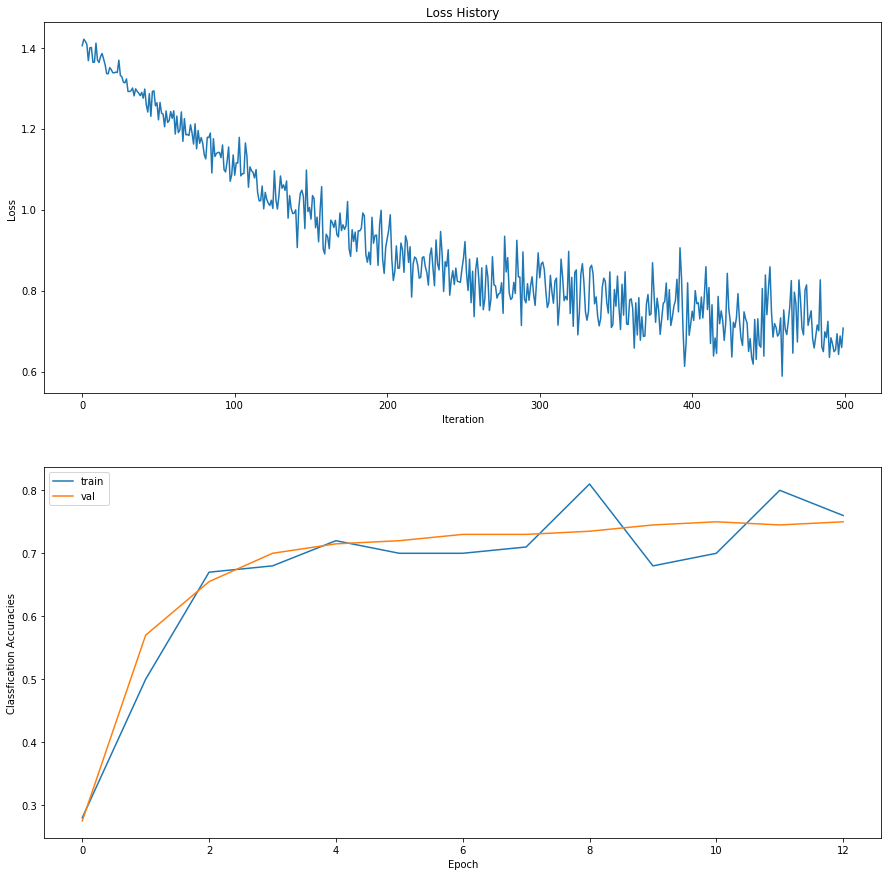

In [95]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.subplot(2,1,1) 
plt.plot(stats['loss_hist'])
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.plot(stats['train_acc_hist'], label='train')
plt.plot(stats['val_acc_hist'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Classfication Accuracies')
plt.legend()
plt.show()

In [96]:
len(all_files)

4400

In [97]:
X_train.shape, X_dev.shape, X_test.shape, X_tiny.shape

((4000, 120000), (500, 120000), (200, 120000), (10, 120000))

In [98]:
y_train.shape, y_dev.shape, y_test.shape, y_tiny.shape

((4000,), (500,), (200,), (10,))

## Make a prediction of an Image file


In [0]:
def predict_random_image():

  idx = random.randint(0,len(y_dev))

  plt.imshow((X_dev[idx]+mean_image).reshape(im_width, im_height, im_channel).astype('uint8'))
  plt.title(num2class[y_dev[idx]])
  plt.show()

  result = net.predict(X_dev[idx].reshape(-1,X_dev[idx].shape[0]))
  print("Prediction: ", num2class[np.asscalar(result)])

In [0]:
plt.rcParams['figure.figsize'] = (11.0, 9.0)

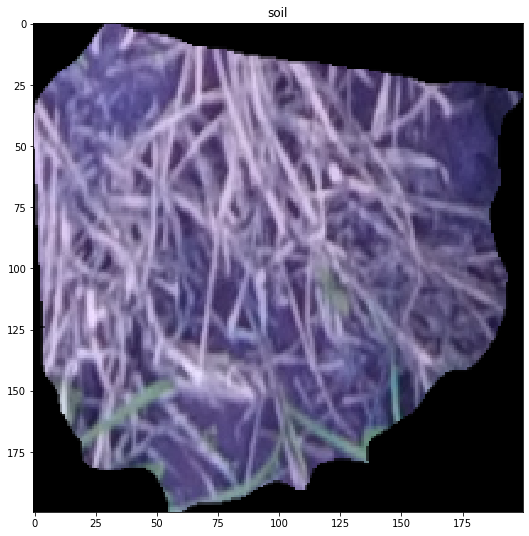

Prediction:  soil


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  # Remove the CWD from sys.path while we load stuff.


In [101]:
predict_random_image()

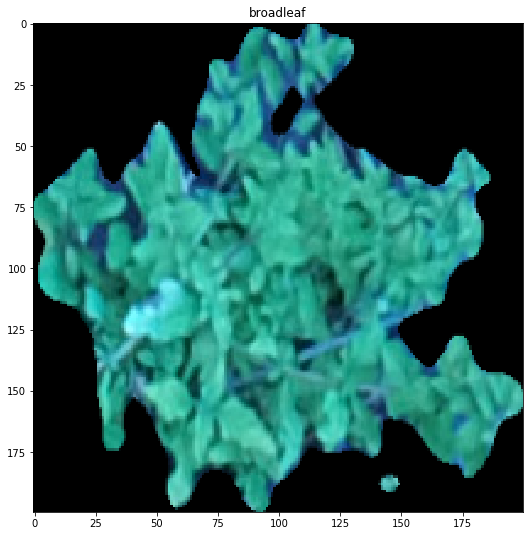

Prediction:  broadleaf


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  # Remove the CWD from sys.path while we load stuff.


In [102]:
predict_random_image()